In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='html5')

In [19]:
# Classes

class Func:
    def __init__(self, func, pars):
        self.func = func
        self.pars = pars
    def __call__(self, *args):
        return self.func(*args, *self.pars)
    
class U_func:
    def __init__(self, main, inits, setting=(False,)):
        self.main = main
        self.init_t = inits[0]
        self.init_r = inits[1]
        self.setting = setting
    def __call__(self, F, *args):
        t, r = args[0], args[1:len(args)]
        if t==-1:
            return self.init_t(*r)
        for x_i in r:
            if x_i==0:
                return self.init_r(t)
        for x_i in r:
            return self.main(F, t, *r)

class Solver:
    def __init__(self, N = 500, M = 50, rng_x = (0,1.0), rng_t = (0, 1.0), name="name"):
        self.name = name
        self.N, self.M = N, M
        self.rng_x = rng_x
        self.rng_t = rng_t

        # spatial domain
        xmin, xmax = rng_x
        tmin, tmax = rng_t
        self.xmin, self.xmax = xmin, xmax
        self.tmin, self.tmax = tmin, tmax

        # x grid of n points
        self.X, self.dx = np.linspace(xmin,xmax,M,retstep=True)
        self.T, self.dt = np.linspace(tmin,tmax,N,retstep=True)

        # each value of the U array contains the solution for all x values at each timestep
        self.U = np.zeros((N, M))

    # explicit euler solution
    def equation(self, funcs, pars, setting=(False,)):
        u_main, init_t, init_r = funcs
        par_main, par_init_t, par_init_r = pars

        init_t_func = Func(init_t, par_init_t)
        init_r_func = Func(init_r, par_init_r)
        init_func = (init_t_func, init_r_func)

        par_main = self.dt, self.dx, *par_main
        main_func = Func(u_main, par_main)

        u_scheme = U_func(main_func, init_func, setting=setting)

        for t in range(self.N):
            for r in range(self.M):
                self.U[t,r] = u_scheme(self.U, t-1, r)

        return self.U, self.X, self.T

class Printer:
    def __init__(self, name="name", xlim=[0,1], ylim=[-2,2]):
        self.name = name
        self.xlim = xlim
        self.ylim = ylim
        
    def animate(self, X, U, Y=np.array([]), G=np.array([])):
        # plot solution
        plt.style.use('dark_background')
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)

        # animate the time data
        def animate_graph(i):
            ax1.clear()
            if G.size!=0:
                x0 = G[i]
                X0 = Y[i]
                plt.plot(X0,x0,color='deepskyblue') #or 'blue' or 'aqua'

            x = U[i]
            plt.plot(X,x,color='lime')

            plt.grid(True)
            plt.ylim(self.ylim)
            plt.xlim(self.xlim)

        anim = animation.FuncAnimation(fig,animate_graph,frames=len(U),interval=20)
        return anim


In [20]:
# Functions

def real_sol(X, T, c, u_0, u_1):
    N = T.size
    T_full = T[-1] - T[0]
    G = np.zeros((N, 4))
    Y = np.zeros((N, 4))
    for t in range(N):
        G[t,0], Y[t,0] = u_1, X[0]
        G[t,1], Y[t,1] = u_1, abs(c) * (t/N * T_full)
        G[t,2], Y[t,2] = u_0, abs(c) * (t/N * T_full)
        G[t,3], Y[t,3] = u_0, X[-1]
    return G, Y


def init_t_base(x, u_0, u_1, point=0):
    return u_1 if x==point else u_0

def init_r_base(t, u_1):
    return u_1

def main_base(F, t, x, dt, dx, a):
    sigma = a*dt/dx
    return F[t,x] - sigma * (F[t,x] - F[t,x-1])

In [21]:
# Constants
N, M = 300, 200
c = 2.0

U0, U1 = 5.0, 10.0

L = 1.0
T = abs(L / c)

In [22]:
# Main
solver = Solver(name="test", N = N, M = M, rng_x = (0,L), rng_t = (0, T))
printer = Printer(name="first", xlim=[0,L], ylim=[U0-1,U1+1])

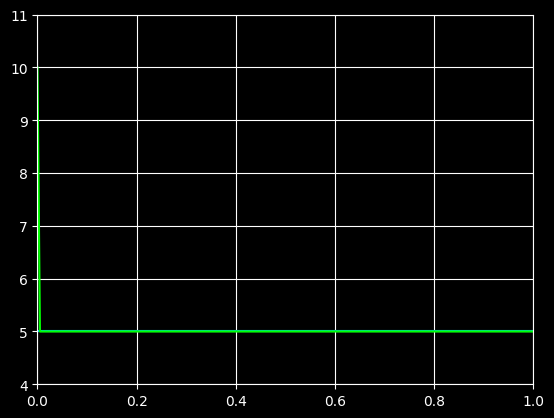

In [23]:
# Scheme_1
funcs = main_base, init_t_base, init_r_base
pars = ((c,), (U0, U1,), (U1,))

U, X, T = solver.equation(funcs=funcs, pars=pars)
G_real, Y_real = real_sol(X, T, c, U0, U1)

animation = printer.animate(X, U, Y=Y_real, G=G_real)
animation